In [1]:
from precovery import precovery_db
from precovery.orbit import Orbit, EpochTimescale
import pandas as pd
import os
import matplotlib.pyplot as plt
from astropy.time import Time
from dataclasses import asdict
import numpy as np
import time
from multiprocessing.pool import Pool
import statistics
import collections

In [2]:
s = 0

In [3]:
pre = precovery_db.PrecoveryDatabase.from_dir("/srv/data/precovery_db/nsc_dr2/ndet4_nside32/")

In [4]:
#use hdf5 instead of csv

In [8]:
max_matches = None
tolerance = 0.0014


In [8]:
orbit_sample = pd.read_csv("data/orbit_sample.csv")

In [9]:
epoch_tdb = Time(orbit_sample.mjd_tdb, scale="tdb", format="mjd")
epoch_utc = epoch_tdb.utc.mjd
orbit_sample['mjd_tdb'] = epoch_utc
orbit_sample

,orb_id,a,e,i,an,ap,ma,mjd_tdb,orb_type
0,2019LU1,1.526907,0.875733,7.350948,75.639405,316.863451,336.094575,58638.999199,NEO
1,2018GR4,0.936050,0.111033,1.004395,167.587963,232.868431,76.288516,59799.999199,NEO
2,2017FO128,1.739187,0.519446,17.129294,174.902988,301.103331,143.395668,59799.999199,NEO
3,2018GE2,1.086291,0.226287,0.474944,42.373753,74.930537,354.804243,59799.999199,NEO
4,2019AU6,0.983432,0.281890,0.348571,301.945762,278.136231,162.592997,59799.999199,NEO
...,...,...,...,...,...,...,...,...,...
117,2001 QA17,2.523522,0.125979,4.221790,16.221720,45.845290,11.554210,59799.999199,MBA
118,4526 P-L,2.433919,0.143933,2.346580,358.002490,138.643630,345.026880,59799.999199,MBA
119,1971 QW1,3.022948,0.081196,9.953170,208.820800,205.751090,191.282760,59799.999199,MBA
120,1951 RB,2.572736,0.147825,8.442690,324.141040,106.567870,16.585010,59799.999199,MBA


In [190]:
data = pd.DataFrame(columns = ['obj_id', 'runtime', 'window_size', 'observation_id'])
data

,obj_id,runtime,window_size,observation_id


In [12]:
def compare(orbit, obj_id, window): #compares lists and adds key of window size and accuracy to dictionary
    start = time.time()
    test = pd.DataFrame([asdict(m) for m in pre.precover(orbit, tolerance = tolerance, max_matches = max_matches, window_size = window)])
    end = time.time()
    return [obj_id, end - start, window, list(test['observation_id'])]

In [13]:
windows = [3, 7, 10, 15, 20, 25, 30, 50, 100, 200]

In [46]:
orb_list = []
for index, row in orbit_sample.iterrows():
    orb_list.append((Orbit.keplerian(
        index,
        row.a,
        row.e,
        row.i,
        row.an,
        row.ap,
        row.ma,
        row.mjd_tdb,
        EpochTimescale.UTC,
        20,
        0.15
    ), 
    row.orb_id
    ))
    

if __name__ == '__main__':
    with Pool(6) as pool:
        for i in windows[:1]:
            items = []
            for j in orb_list[:3]:
                items += [(j[0], j[1], i)]
                for result in pool.starmap(compare, items):
                    data.loc[result[0] + ' Size ' + str(result[2])] = result

/opt/tljh/user/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3162: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim
/opt/tljh/user/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3162: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


In [14]:
data

,obj_id,runtime,window_size,observation_id


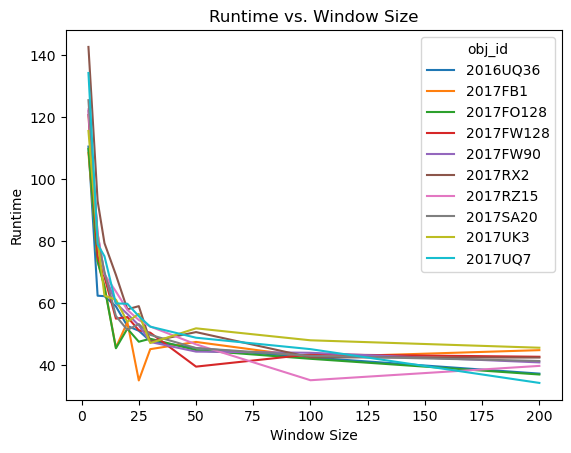

In [141]:
def timevwindow(obj_id, df):
    # fit = np.polyfit(np.log(df[df['obj_id'] == obj_id]['runtime']), df[df['obj_id'] == obj_id]['window_size'], 1)
    plt.plot(df[df['obj_id'] == obj_id]['window_size'], df[df['obj_id'] == obj_id]['runtime'], 'ro')
    # plt.plot(df[df['obj_id'] == obj_id]['runtime'], fit[0] + fit[1]*np.log(df[df['obj_id'] == obj_id]['runtime']))
    plt.title('Runtime vs. Window Size of ' + obj_id)
    plt.xlabel('Window Size')
    plt.ylabel('Runtime (sec)')
    plt.show()
def completenessvwindow(obj_id, df):
    # fit = np.polyfit(np.log(df[df['obj_id'] == obj_id]['accuracy']), df[df['obj_id'] == obj_id]['window_size'], 1)
    plt.plot(df[df['obj_id'] == obj_id]['window_size'], df[df['obj_id'] == obj_id]['accuracy'], 'ro')
    # plt.plot(df[df['obj_id'] == obj_id]['accuracy'], fit[0] + fit[1]*np.log(df[df['obj_id'] == obj_id]['accuracy']))
    plt.title('Runtime vs. Window Size of ' + obj_id)
    plt.xlabel('Window Size')
    plt.ylabel('Accuracy')
    plt.show()
    
copy = data.pivot(index = 'window_size', columns = 'obj_id', values = 'runtime')
copy.iloc[:, 80: 90].plot()
plt.title('Runtime vs. Window Size')
plt.xlabel('Window Size')
plt.ylabel('Runtime')
plt.show()


In [6]:
def accuracy(orbit_name, data_frame):
    base = len(list(data_frame.loc[orbit_name + ' Size 3']['observation_id']))
    lst = list(data_frame[data_frame['obj_id'] == orbit_name]['observation_id'])
    return [len(i) / base if base > 0 else 0.0 for i in lst]
        

In [89]:
accuracy('458508 (2011 CM42)', data), accuracy('(2014 HD196)', data), accuracy('Cameron-ISON (P/2015 PD229)', data)

([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])

In [10]:
data = pd.read_hdf('data/eyoo_timing_data.h5', key = 'df')
data = data.sort_values(by = ['obj_id', 'window_size'], ascending = [True, True])
data

,obj_id,runtime,window_size,observation_id
1951 RB Size 3,1951 RB,68.664297,3,"[c4d.570123.16.7976, c4d.662389.28.748, c4d.66..."
1951 RB Size 7,1951 RB,47.208407,7,"[c4d.570123.16.7976, c4d.662389.28.748, c4d.66..."
1951 RB Size 10,1951 RB,43.152929,10,"[c4d.570123.16.7976, c4d.662389.28.748, c4d.66..."
1951 RB Size 15,1951 RB,39.323345,15,"[c4d.570123.16.7976, c4d.662389.28.748, c4d.66..."
1951 RB Size 20,1951 RB,34.584453,20,"[c4d.570123.16.7976, c4d.662389.28.748, c4d.66..."
...,...,...,...,...
A887 TB Size 25,A887 TB,41.430933,25,"[c4d.659704.1.68, c4d.659703.50.469, c4d.65967..."
A887 TB Size 30,A887 TB,44.175508,30,"[c4d.661950.50.736, c4d.659704.1.68, c4d.65970..."
A887 TB Size 50,A887 TB,44.366193,50,"[c4d.661950.50.736, c4d.659704.1.68, c4d.65970..."
A887 TB Size 100,A887 TB,38.444810,100,"[c4d.661950.50.736, c4d.659704.1.68, c4d.65970..."


In [11]:
orbit_sample = orbit_sample.sort_values(by = ['orb_id'])
orbit_sample

,orb_id,a,e,i,an,ap,ma,mjd_tdb,orb_type
120,1951 RB,2.572736,0.147825,8.442690,324.141040,106.567870,16.585010,59799.999199,MBA
119,1971 QW1,3.022948,0.081196,9.953170,208.820800,205.751090,191.282760,59799.999199,MBA
85,1976 GV3,2.471325,0.089354,0.828360,262.523210,315.031700,330.880510,59799.999199,MBA
92,1979 MQ1,2.680684,0.138280,12.319500,281.420360,344.825180,313.936970,59799.999199,MBA
73,1979 MX1,2.781729,0.046287,3.503970,268.719330,299.766420,183.391680,59799.999199,MBA
...,...,...,...,...,...,...,...,...,...
55,2021JH,2.253001,0.616274,0.390188,207.776875,318.477537,11.771369,59335.999199,NEO
52,2022KF6,2.195037,0.535258,11.959863,69.313597,179.631179,21.392962,59799.999199,NEO
118,4526 P-L,2.433919,0.143933,2.346580,358.002490,138.643630,345.026880,59799.999199,MBA
65,4603 P-L,3.191611,0.200506,3.038870,81.891370,351.327320,246.314180,59799.999199,MBA


In [12]:
def counter(obj_id, df):
    return [1 if collections.Counter(list(df[df['obj_id'] == obj_id]['observation_id'])[0]) == collections.Counter(list(df[df['obj_id'] == obj_id]['observation_id'])[i]) else 0 for i in range(len(list(df[df['obj_id'] == obj_id]['observation_id'])))]

In [13]:
accuracies = []
for i in list(orbit_sample['orb_id']):
    accuracies += (counter(i, data))
len(accuracies)

1220

In [14]:
data['accurate'] = accuracies

In [15]:
data

,obj_id,runtime,window_size,observation_id,accurate
1951 RB Size 3,1951 RB,68.664297,3,"[c4d.570123.16.7976, c4d.662389.28.748, c4d.66...",1
1951 RB Size 7,1951 RB,47.208407,7,"[c4d.570123.16.7976, c4d.662389.28.748, c4d.66...",1
1951 RB Size 10,1951 RB,43.152929,10,"[c4d.570123.16.7976, c4d.662389.28.748, c4d.66...",1
1951 RB Size 15,1951 RB,39.323345,15,"[c4d.570123.16.7976, c4d.662389.28.748, c4d.66...",1
1951 RB Size 20,1951 RB,34.584453,20,"[c4d.570123.16.7976, c4d.662389.28.748, c4d.66...",1
...,...,...,...,...,...
A887 TB Size 25,A887 TB,41.430933,25,"[c4d.659704.1.68, c4d.659703.50.469, c4d.65967...",1
A887 TB Size 30,A887 TB,44.175508,30,"[c4d.661950.50.736, c4d.659704.1.68, c4d.65970...",1
A887 TB Size 50,A887 TB,44.366193,50,"[c4d.661950.50.736, c4d.659704.1.68, c4d.65970...",1
A887 TB Size 100,A887 TB,38.444810,100,"[c4d.661950.50.736, c4d.659704.1.68, c4d.65970...",1


In [16]:
data[data['accurate'] == 1]

,obj_id,runtime,window_size,observation_id,accurate
1951 RB Size 3,1951 RB,68.664297,3,"[c4d.570123.16.7976, c4d.662389.28.748, c4d.66...",1
1951 RB Size 7,1951 RB,47.208407,7,"[c4d.570123.16.7976, c4d.662389.28.748, c4d.66...",1
1951 RB Size 10,1951 RB,43.152929,10,"[c4d.570123.16.7976, c4d.662389.28.748, c4d.66...",1
1951 RB Size 15,1951 RB,39.323345,15,"[c4d.570123.16.7976, c4d.662389.28.748, c4d.66...",1
1951 RB Size 20,1951 RB,34.584453,20,"[c4d.570123.16.7976, c4d.662389.28.748, c4d.66...",1
...,...,...,...,...,...
A887 TB Size 25,A887 TB,41.430933,25,"[c4d.659704.1.68, c4d.659703.50.469, c4d.65967...",1
A887 TB Size 30,A887 TB,44.175508,30,"[c4d.661950.50.736, c4d.659704.1.68, c4d.65970...",1
A887 TB Size 50,A887 TB,44.366193,50,"[c4d.661950.50.736, c4d.659704.1.68, c4d.65970...",1
A887 TB Size 100,A887 TB,38.444810,100,"[c4d.661950.50.736, c4d.659704.1.68, c4d.65970...",1


In [25]:
data_copy = 0
data_copy = data[data['accurate'] == 1]
data_copy = data_copy[(data_copy['window_size']==3) | (data_copy['window_size']==10)]
data_copy

,obj_id,runtime,window_size,observation_id,accurate
1951 RB Size 3,1951 RB,68.664297,3,"[c4d.570123.16.7976, c4d.662389.28.748, c4d.66...",1
1951 RB Size 10,1951 RB,43.152929,10,"[c4d.570123.16.7976, c4d.662389.28.748, c4d.66...",1
1971 QW1 Size 3,1971 QW1,56.227118,3,"[c4d.243450.17.22, c4d.243066.35.1165, c4d.243...",1
1971 QW1 Size 10,1971 QW1,35.213490,10,"[c4d.243450.17.22, c4d.243066.35.1165, c4d.243...",1
1976 GV3 Size 3,1976 GV3,88.259458,3,"[c4d.164701.4.57, c4d.417265.8.184, c4d.599721...",1
...,...,...,...,...,...
4526 P-L Size 3,4526 P-L,72.152231,3,"[c4d.392846.45.420, c4d.392845.45.645, c4d.430...",1
4603 P-L Size 3,4603 P-L,95.205563,3,"[c4d.441414.45.58, c4d.659671.7.37, c4d.662340...",1
4603 P-L Size 10,4603 P-L,60.289896,10,"[c4d.441414.45.58, c4d.659671.7.37, c4d.662340...",1
A887 TB Size 3,A887 TB,93.552847,3,"[c4d.659704.1.68, c4d.659703.50.469, c4d.65967...",1


In [26]:
data_copy = data_copy.groupby(['obj_id']).agg({'runtime': ['min', 'max'], 'window_size': ['min', 'max']})


In [27]:
len(data_copy[data_copy[('window_size', 'max')] == 200]) / 122

0.0

In [31]:
res = [1 - (i / j) for i, j in zip(list(data_copy['runtime']['min']), list(data_copy['runtime']['max']))]
res
data_copy['time_reduction'] = res
data_copy = data_copy[data_copy['time_reduction'] > 0]
data_copy

runtime             window_size     time_reduction
                min         max         min max               
obj_id                                                        
1951 RB   43.152929   68.664297           3  10       0.371538
1971 QW1  35.213490   56.227118           3  10       0.373728
1976 GV3  57.338471   88.259458           3  10       0.350342
1979 MQ1  59.295873   96.416705           3  10       0.385004
1979 MX1  60.085065   98.341232           3  10       0.389015
...             ...         ...         ...  ..            ...
2020TF6   84.169784  135.462097           3  10       0.378647
2021JH    55.412835   93.724999           3  10       0.408772
2022KF6   62.948696  105.697123           3  10       0.404443
4603 P-L  60.289896   95.205563           3  10       0.366740
A887 TB   57.500856   93.552847           3  10       0.385365

[117 rows x 5 columns]

In [32]:
statistics.mean(list(data_copy['time_reduction']))

0.3646539357882218

In [30]:
min(list(data_copy['time_reduction']))

0.0

In [206]:
min(list(data_copy['window_size']['max']))

10

In [207]:
# for i in list(orbit_sample['orb_id']):
#     timevwindow(i, data)

In [209]:
data_max = 0
data_max = data[data['accurate'] == 1]
data_max = data_max.groupby(['obj_id']).agg({'runtime': ['min', 'max'], 'window_size': ['min', 'max']})
data_max

runtime             window_size     
                min         max         min  max
obj_id                                          
1951 RB   27.392527   68.664297           3  200
1971 QW1  23.079719   56.227118           3  200
1976 GV3  38.838294   88.259458           3  200
1979 MQ1  40.013160   96.416705           3  200
1979 MX1  40.303410   98.341232           3  200
...             ...         ...         ...  ...
2021JH    34.277107   93.724999           3  200
2022KF6   35.553816  105.697123           3  200
4526 P-L  27.894994   72.152231           3  200
4603 P-L  37.579627   95.205563           3  200
A887 TB   38.444810   93.552847           3  200

[122 rows x 4 columns]

In [210]:
res = [1 - (i / j) for i, j in zip(list(data_max['runtime']['min']), list(data_max['runtime']['max']))]
data_max['time_reduction'] = res
data_max

runtime             window_size      time_reduction
                min         max         min  max               
obj_id                                                         
1951 RB   27.392527   68.664297           3  200       0.601066
1971 QW1  23.079719   56.227118           3  200       0.589527
1976 GV3  38.838294   88.259458           3  200       0.559953
1979 MQ1  40.013160   96.416705           3  200       0.584998
1979 MX1  40.303410   98.341232           3  200       0.590168
...             ...         ...         ...  ...            ...
2021JH    34.277107   93.724999           3  200       0.634280
2022KF6   35.553816  105.697123           3  200       0.663626
4526 P-L  27.894994   72.152231           3  200       0.613387
4603 P-L  37.579627   95.205563           3  200       0.605279
A887 TB   38.444810   93.552847           3  200       0.589058

[122 rows x 5 columns]

In [211]:
data_max.sort_values(by = [('window_size', 'max')])

runtime             window_size      time_reduction
                  min         max         min  max               
obj_id                                                           
2014HD198   47.984999   73.049251           3   10       0.343114
2018RB2     51.972605  100.648916           3   25       0.483625
2018RW      55.658226  141.115428           3   25       0.605584
2018SD2     51.833165  118.117097           3   25       0.561171
2017RX2     47.540283  142.597929           3   30       0.666613
...               ...         ...         ...  ...            ...
2000 DV99   34.814546   79.213240           3  200       0.560496
2000 AR108  28.472967   84.317176           3  200       0.662311
1999 XS117  23.457768   58.479739           3  200       0.598874
4603 P-L    37.579627   95.205563           3  200       0.605279
A887 TB     38.444810   93.552847           3  200       0.589058

[122 rows x 5 columns]

In [213]:
min(list(data_max['time_reduction']))

0.2984906724893527